### First things first, let's run the cell below to load the libraries and set up the plotting defaults...   

In [4]:


import osiris
#import landau-helper
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpmath import *
from h5_utilities import *

## for widgets
import glob
from ipywidgets import interact_manual,fixed,Layout,interact, FloatSlider
##

import ipywidgets as widgets
interact_calc=interact_manual.options(manual_name="Make New Input and Run")
import os

plt.rc('font',size=20,family="serif")
%matplotlib inline

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 32 


def plot_tk_ldi(rundir, field, modeno=6,tlim=300):




    title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
    axis_font = {'fontname':'Arial', 'size':'34'}
    # initialize values
    PATH = os.getcwd() + '/' + rundir +'/'+ field + '.h5'
    hdf5_data = read_hdf(PATH)

#    hdf5_data = FFT_hdf5(hdf5_data)         # FFT the data (x-t -> w-k)
    k_data=np.fft.fft(hdf5_data.data,axis=1)
    hdf5_data.data=np.abs(k_data)

    nx=hdf5_data.data.shape[1]
    nt=hdf5_data.data.shape[0]
    taxis=np.linspace(0,hdf5_data.axes[1].axis_max,nt)
    deltak=2.0*3.1415926/nx


#    N = 100
#    dx = float(klim)/N
#    kvals = np.arange(0, klim+.01, dx)
#    wvals = kvals * c_s
    N=100
#    dt = float(tlim)/N
#    tvals=np.arange(0,tlim,dt)
#    kvals=np.zeros(N)
#    for i in range(0,N):
#        kvals[i]=np.sqrt(2)


    # create figure
    plt.figure(figsize=(8,6))

    SMALL_SIZE = 20
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 32
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#plt.figure(figsize=(12,8))
    plt.semilogy(taxis,hdf5_data.data[:,modeno],label='PIC simulation, mode ='+repr(modeno))
#    plt.semilogy(taxis,landau_theory2,'g',label=label2)
    plt.ylabel('mode'+repr(modeno))
    plt.xlabel('Time [$1/ \omega_{p}$]')
    plt.legend()
    plt.xlim(0,tlim)



#    plt.xlabel(' α ',**axis_font)
#    plt.ylabel(' Time  [$1/ \omega_{pe}$]',**axis_font)
#    plt.xlim(0,klim)
#    plt.ylim(0,tlim)
    plt.show()

    

def landau_damping_deck_maker(iname='ldi-ions.txt', oname='case1.txt', amp=0.3,
             wavew = 1.03, wavemode=6,tend=100):


    with open(iname) as osdata:
        data = osdata.readlines()

    for i in range(len(data)):
        if 'AMP =' in data[i]:
            data[i] = ' AMP = '+str(amp)+',\n'
        if 'WAVEW' in data[i]:
            data[i] = ' WAVEW = '+str(wavew)+',\n'
        if 'WAVEMODE' in data[i]:
            data[i] = ' WAVEMODE = '+str(wavemode)+',\n'
        if 'TEND' in data[i]:
            data[i] = ' TEND = '+str(tend)+',\n'

    with open(oname,'w') as f:
        for line in data:
            f.write(line)
    
    print('New file '+oname+' is written.')
    dirname = oname.strip('.txt')
    print('Running OSIRIS in directory '+dirname+'...')
    osiris.run_upic_es(rundir=dirname,inputfile=oname)
    outdirname=oname.split(".")[0]
    print(outdirname)
    # e_history=energy_history(dirname=outdirname)
    # taxis=np.arange(len(e_history))*0.2
    # plt.plot(taxis,e_history)
    # plt.title('Energy Deviation vs Time (in %)')
    # plt.xlabel('Time ($\omega_p^{-1}$)')   
    # plt.show()
 #
    osiris.plot_tk_arb(outdirname,'pot',klim=0.5,tlim=tend)
    plot_tk_ldi(outdirname,'pot',modeno=wavemode,tlim=tend)
    
    print('Done')

def landau_damping_widget():
    style = {'description_width': '350px'}
    layout = Layout(width='55%')

    a = widgets.Text(value='landau-kd035.txt', description='Template Input File:',style=style,layout=layout)
    b = widgets.Text(value='case1.txt', description='New Output File:',style=style,layout=layout)
    c = widgets.BoundedFloatText(value=0.3, min=0.0, max=5.0, description='Driver Amplitude:',style=style,layout=layout)
    d = widgets.FloatText(value=1.18,description='Driver Frequency (in omega_pe):',style=style,layout=layout)
    e = widgets.IntSlider(value=13,min=1,max=22,step=1,description='Driver Wave Number (integer, fundamental modes of box):',
                          style=style,layout=layout)
    f = widgets.FloatText(value=100.0,description='TEND or the Total Simulation Time:',style=style,layout=layout)
  

    im = interact_calc(landau_damping_deck_maker, iname=a,oname=b,amp=c,wavew=d, wavemode = e, tend=f);
    
    im.widget.manual_button.layout.width='250px'

## Landau Damping with UPIC-ES





The normalization for UPIC are as follows. Note that  Δ  is the size of the cell:

Time:  𝑡′=𝑡𝜔𝑝𝑒 
Frequency:  𝜔′=𝜔𝜔𝑝 

Position:  𝑥⃗ ′=𝜔𝑝𝑐𝑥⃗ /Δ 

Velocity:  𝑣⃗ ′=𝑣⃗ 𝜔𝑝Δ 

Electric field:  𝐸⃗ ′=𝑒𝑚𝑒1𝜔2𝑝Δ𝐸⃗  

(There is no magnetic field as the code is purely electrostatic)

### Introduction

Waves are a fundamental collective process in plasmas. The plasma state is rich in wave phenomena. One of the basic properties of plasmas, charge neutrality, is mediated by Langmuir waves. In most plasmas of interest, the ions are much heavier than the electrons and thus the ions move little compared to the electrons. When the electrons are displaced, an electric field develops to maintain charge neutrality, which accelerates the electrons back towards the ions. The electrons will overshoot and effectively slosh around the stationary ions. These oscillations are known by a variety of names: Langmuir oscillations, space charge waves, or simply plasma oscillations. For a stationary cold plasma, there are non-propagating modes at the plasma frequency. These modes become propagating modes when the plasma drifts at a constant speed. These can be studied in the fluid description if we choose an equation of state, i.e., if we have a model for pressure as a function of density and temperature.

#### Fluid Dispersion Relation
We consider a plasma with warm electrons and cold ions. First we choose the ideal equation of state, $P=\gamma \tilde{n}_e T_e$, where $\gamma \approx 3$ is the adiabatic index obtained from kinetic theory. We can then write the five linearized fluid equations. First we have the Navier-Stokes equations for both the electrons and ions, respectively:

\begin{equation}
		\frac{\partial}{\partial t}\tilde{\mathbf{v}}_e=-\frac{e}{m_e}\tilde{\mathbf{E}}-\frac{\gamma T_e}{m_e n_{0e}}\nabla \tilde{n}_e\\
		\frac{\partial}{\partial t} \tilde{\mathbf{v}}_i=\frac{Ze}{m_i}\tilde{\mathbf{E}}.
\end{equation}

The continuity equations are

\begin{equation}
		\frac{\partial}{\partial t}\tilde{n}_e+\nabla \cdot [n_{0e}\tilde{\mathbf{v}}_e]=0\\
		\frac{\partial}{\partial t}\tilde{n}_i+\nabla \cdot [n_{0i}\tilde{\mathbf{v}}_i]=0,
\end{equation}

and finally Poisson's equation is given as
\begin{equation}
	\nabla \cdot \tilde{\mathbf{E}}=-4 \pi e (\tilde{n}_e-Z\tilde{n}_i).
\end{equation}
We then take the divergence of the Navier-Stokes equations and the time derivative of the continuity equations and combine. We then go Fourier space by assuming plane wave solutions, i.e., $\partial_t \rightarrow -i\omega$ and $\nabla \rightarrow ik$. Solving the resulting equation for $\tilde{n}_e$ gives
\begin{equation}
	\tilde{n}_e=\frac{-\frac{e n_{0e}}{m_e}i\mathbf{k}\cdot\tilde{\mathbf{E}}}{\omega^2-\frac{\gamma T_e k^2}{m_e n_{0e}}}
\end{equation}
We get a similar result for ions, but without the pressure term. We then substitute these into Poisson's Equation and collect terms to get
\begin{equation}
	\left( 1-
    \frac{\omega_{pi}^2}{\omega ^2} 
    - \frac{\omega_{pe}^2}{\omega^2}
    \left( 1 + \frac{\gamma T_e k^2}{\omega^2 m_e n_{0e}} \right)    
    \right) 
    \mathbf{k}\cdot\tilde{\mathbf{E}}=0.
\end{equation}
Since $\nabla \cdot \tilde{\mathbf{D}} = \nabla \cdot (\epsilon \tilde{\mathbf{E}}) = \epsilon \mathbf{k} \cdot \tilde{\mathbf{E}}$, the term in parenthesis is then our dielectric constant. Setting this equal to zero and assumes the ion mass to be infinite (and ignore the $\omega_{pi}$ contribution) gives the (Bohm-Gross) dispersion relation,
\begin{equation}
	\omega^2=\omega_{pe}^2+\gamma \bar{v}_e^2 k^2,
\end{equation}
where $\bar{v}_e^2=T_e/m_e$, and we have neglected the ion contribution because it is small compared to the electron contribution for Langmuir waves. So we see that the pressure term provides an additional term to the dispersion relation (the stationary solution is just $\omega^2=\omega_{pe}^2$).

### Kinetic Dispersion Relation:

The Langmuir description (shown above) lacks kinetic damping. A more accurate (and complete) dispersion relation, which includes kinetic effects, can be obtained by treating the plasma wave problem as an initial value problem and using a Laplace transform in time, which allows for damping.  Following this line of logic, the plasma dispersion becomes: 

\begin{equation}
\epsilon(\omega,k) = 1 + \sum_{s} \chi_s(\omega,k)
\end{equation}

with no approximation, and taking causality into account, the plasma susceptibility $\chi_s$ can be written as (the full derivation can be found in the classic paper by Landau):
\begin{equation}
\chi_s (\omega,k) = \frac{1}{2} \left( \frac{\omega_{p,s}}{k v_{t,s} } \right)^2 
Z'(\frac{\omega} {\sqrt{2}k v_{t,s}} )
\end{equation}
Therefore, for a Maxwellian plasma and infinitely massive, cold ion, the plasma dispersion relation becomes:
\begin{equation}
1 - 0.5 * \left( \frac{\omega_{p,e}}{k v_{t,e} } \right)^2 
Z'(\frac{\omega} {\sqrt{2}k v_{t,e}} ) = 0
\end{equation}

The above expression do not yield to easy expresssions, but some asymptotic limits are available.  For example, for very large phase velocities, or $k \lambda_D < 0.25$, the Bohm-Gross dispersion relation (shown above) works very well.  

In the weak damping limit, one can obtain an approximation for the damping rate.  This is given both in the original paper by Landau (equation (1.2)) and a more accurate expression was also obtained by J. D. Jackson in 1960 (equation (6.3) in J. D. Jackson, J. Nucl. Eng. Part C Plasma Physics 1, 171 (1960).) For a small range of $k \lambda_D$, typically $k \lambda_D < 0.5$ (as shown in Figure (3) of the Jackson paper), the damping rate can be approximated by the expression:  

\begin{equation}
 \gamma /\omega << 1
\end{equation}



\begin{equation}
\gamma = \frac{ \epsilon_I(k,\omega(k))}
{\frac{\partial}{\partial \omega} \epsilon_R(k,\omega(k))}\\
\end{equation}

\begin{equation}
\gamma = - \sqrt{\frac{\pi}{8}} \frac{1}{(k \lambda_D)^3} \ exp(-\frac{2}{3}) \ \
exp \left(- \left({\frac{k_D}{\sqrt{2}k}}\right)^2 \right)
\end{equation}

Below we first plot the exact result vs the Jackson estimate for a large range of $k \lambda_D$.








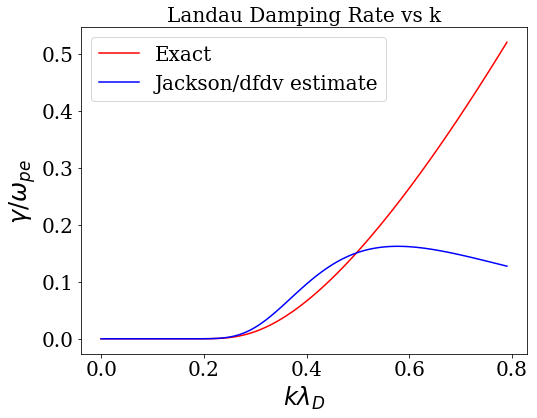

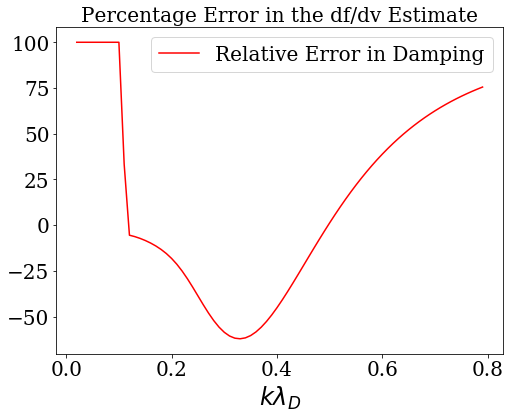

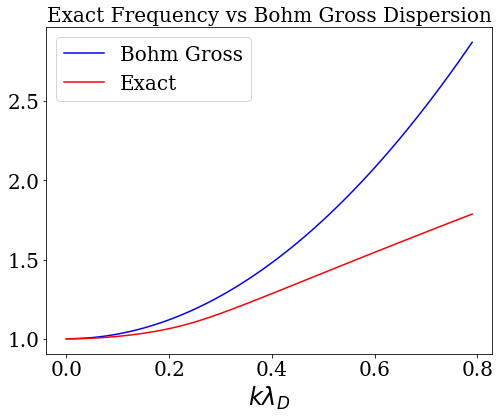

In [2]:
karray=np.arange(0.0,0.8,0.01)
[damping, frequency]=osiris.landau(karray)
damping_estimate=np.sqrt(np.pi/8)*1.0/(karray*karray*karray+1e-5)*np.exp(-1.5)*np.exp(-1/(2*karray*karray+1e-5))
damping_estimate[0]=0.0
frequency[0]=1.0
 
   
plt.figure(figsize=(8,6))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 
plt.plot(karray,np.abs(damping),'r',label='Exact')
plt.plot(karray,damping_estimate,'b',label='Jackson/dfdv estimate')
plt.xlabel('$k \lambda_D$')
plt.ylabel('$\gamma/\omega_{pe}$')
plt.title('Landau Damping Rate vs k')
# plt.xlim(0,0.3)
plt.legend()

  
plt.show()


plt.figure(figsize=(8,6))
plt.plot(karray[2:],100*(1-np.abs(damping_estimate[2:]/np.abs(damping[2:]))),'r',label='Relative Error in Damping')
plt.legend()
plt.xlabel('$k \lambda_D$')

plt.title('Percentage Error in the df/dv Estimate')
plt.show()
landau_exact=scipy.interpolate.interp1d(karray,np.abs(damping),kind='cubic')
landau_estimate=scipy.interpolate.interp1d(karray,damping_estimate,kind='cubic')



plt.figure(figsize=(8,6))
bohm_gross=(1+3*karray*karray)
plt.plot(karray,bohm_gross,'b',label='Bohm Gross')
plt.plot(karray, frequency,'r', label='Exact')
plt.title('Exact Frequency vs Bohm Gross Dispersion')
plt.xlabel('$k \lambda_D$')


plt.legend()
plt.show()

## UPIC Simulation:


###  CASE 1:  k $\lambda_D$ = 0.319

The simulation is done with the electrostatic PIC code UPIC-ES.  The simulation is periodic in 1D with 256 cells across.  There are 4 million ($2^{22}$) particles in the simulation box, which translates to roughly 16,384 particles per cell.  The initial thermal velocity is 1, which means the grid size is exactly one Debye length.


A external traveling electric field at mode 13 ($k \lambda_D = 0.319$) is applied to the system at t=0.  The frequency of the wave is obtained from the kinetic dispersion relation ($\omega/\omega_p = 1.18$).  The external electric field is left on for a duration of $3.5 \omega_{pe}^{-1}$, and then the system is allowed to evolve self-consistently.  

To obtain the damping rate, we observe the temporal behavior of the wave that is excited by the external driver and perform an exponential fit, using both the exact root and also the $df/dv$ estimate.




In [2]:
dirname = 'landau-kd035'
osiris.run_upic_es(rundir=dirname,inputfile='landau-kd035.txt')

combine_h5_2d completed normally
runbeps completed normally


####  In the cell below we look at the overall time history of the electrostatic potential, you can see the mode driven at k=.319.

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


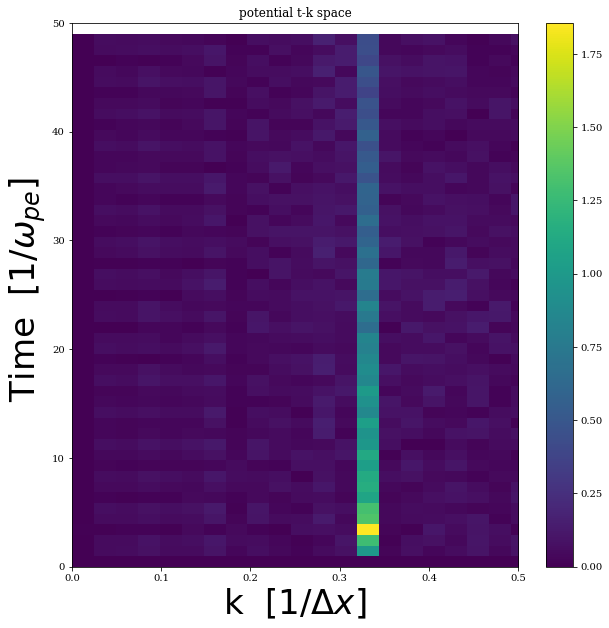

In [28]:
dirname = 'landau-kd035'

osiris.plot_tk_arb(dirname,'Ex',klim=0.5,tlim=50)
#rundir, field, title='potential', klim=5,tlim=100

#### Here we look at the time history of mode 13, the mode that is driven in this simulation, and compare the damping rate against the exact solution, and the df/dv estimate given by Jackson.

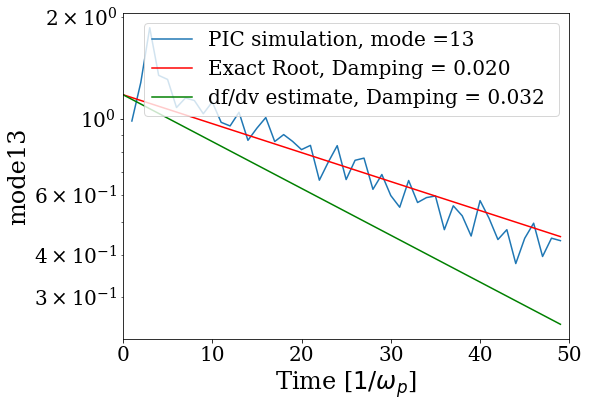

In [4]:
dirname = 'landau-kd035'
landau_exact=scipy.interpolate.interp1d(karray,np.abs(damping),kind='cubic')
landau_estimate=scipy.interpolate.interp1d(karray,damping_estimate,kind='cubic')
theory_exact=landau_exact(26.0*np.pi/256.0)
theory_estimate=landau_estimate(26.0*np.pi/256.0)
osiris.plot_tk_landau_theory(dirname,'Ex',modeno=13,theory1=theory_exact,theory2=theory_estimate,init_amplitude=1.18,tlim=50)
#rundir, field, title='potential', klim=5,tlim=100



###  CASE 2:  k $\lambda_D$ = 0.54

Here we investigate the behavior of a linear plasma wave at a much higher $k \lambda_D$.   In this case, $k \lambda_D$ =0.54.  The driver frequency (taken from the exact solution) is $\omega/\omega_{pe} = 1.46$.   

Because the damping rate here is 9 times higher than the first case (0.18 instead of 0.02 $\omega_pe$).  We reduce the simulation time from $T=50 \omega_p^{-1}$ to $T=25 \omega_p^{-1}$.  The driven wave damps by a factor of approximately $\exp(4.5)=90.02$ in that time. 







In [3]:
dirname = 'landau-kd054'
osiris.run_upic_es(rundir=dirname,inputfile='landau-kd054.txt')

combine_h5_2d completed normally
runbeps completed normally


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


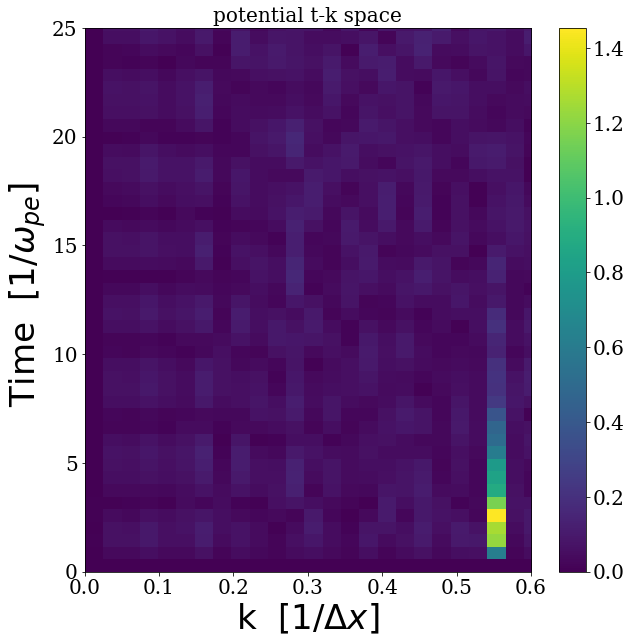

In [5]:
dirname = 'landau-kd054'


osiris.plot_tk_arb(dirname,'Ex',klim=0.6,tlim=25)
#rundir, field, title='potential', klim=5,tlim=100

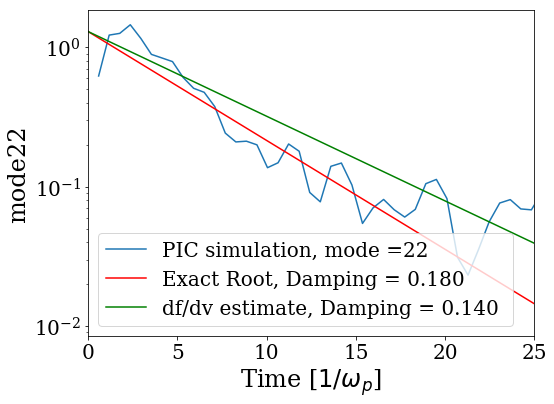

In [6]:
dirname = 'landau-kd054'

landau_exact=scipy.interpolate.interp1d(karray,np.abs(damping),kind='cubic')
landau_estimate=scipy.interpolate.interp1d(karray,damping_estimate,kind='cubic')
theory_exact=landau_exact(44.0*np.pi/256.0)
theory_estimate=landau_estimate(44.0*np.pi/256.0)
osiris.plot_tk_landau_theory(dirname,'Ex',modeno=22,theory1=0.18,theory2=0.14,init_amplitude=1.3,tlim=25)
#rundir, field, title='potential', klim=5,tlim=100

### Some questions to consider:
    
    * How good is the df/dv estimate?  
    * What happens if the driver amplitude increases?  What are some nonlinear effects?


## Simulation Sandbox for Landau Damping:

Here you can excite a plasma wave and look at Landau damping.  You can specify 

* amplitude
* wave number
* frequency
* duration of the simulation

these simulations use a lot of particles to reduce noise so they take some time to run.  Please be patient.



In [6]:
landau_damping_widget()
# osiris.plot_wk_arb(rundir='case1',field='Ex',TITLE='EPW dispersion curve',klim=3,wlim=2)
# test3=energy_history(dirname='case1')
# taxis=np.arange(1000)*0.2
# plt.plot(taxis,test3)
# plt.title('Energy Deviation vs Time (in %)')
# plt.xlabel('Time ($\omega_p^{-1}$)')

interactive(children=(Text(value='landau-kd035.txt', description='Template Input File:', layout=Layout(width='…

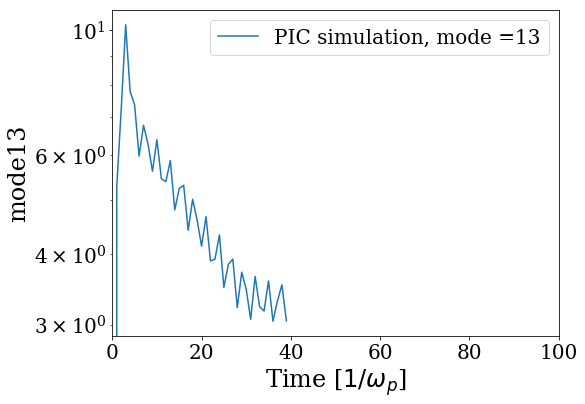

In [10]:
plot_tk_ldi('case1','Ex',modeno=13,tlim=100)


In [9]:
import os
cwd = os.getcwd()
print(cwd)

/home/jovyan/work/JupyterPIC/dev/Landau-Damping


#### Sandbox:

So, from the examples above, you can see energy conservation is not necessarily the sole criteria in judging the "correctness" of a simulation.  Below you can change the temperature and the smoothing factor for UPIC, and see how the behavior changes as you make these changes.